# Model: GridWorld

### use epsilon-greedy

In [1]:
print('-------------------------')
print('|     |     |     | +1  |')
print('-------------------------')
print('|     |//// |     | -1  |')
print('-------------------------')
print('|start|     |     |     |')
print('-------------------------')

-------------------------
|     |     |     | +1  |
-------------------------
|     |//// |     | -1  |
-------------------------
|start|     |     |     |
-------------------------


## Prepare

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
from grid_world import standard_grid, negative_grid, print_values, print_policy

In [7]:
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

#### epsilon_greedy

In [2]:
def random_action(a, eps=0.1):
    # we'll use epsilon-soft to ensure all states are visited
    # what happens if you don't do this? i.e. eps=0
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

#### utility function

In [3]:
def max_dict(d):
    # returns the argmax (key) and max (value) from a dictionary
    # put this into a function since we are using it so often
    max_key = None
    max_val = float('-inf')
    for k, v in d.iteritems():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

## Case One: SARSA

#### rewards

In [15]:
grid = negative_grid(step_cost=-0.1)
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10| -0.10| -0.10|  1.00| 
---------------------------
-0.10|  0.00| -0.10| -1.00| 
---------------------------
-0.10| -0.10| -0.10| -0.10| 


#### initializer: Q

In [16]:
Q = {}
states = grid.all_states()
for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0

In [17]:
# keep track of #Q[s] updated
update_counts = {}
update_counts_sa = {}
for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        update_counts_sa[s][a] = 1.0

#### Iteration (value iteration)

In [18]:
# Value convergency:
t = 1.0
deltas = []
for it in xrange(10000):
    if it % 100 == 0:
        t += 1e-2
    if it % 2000 == 0:
        print("it:", it)

    # instead of 'generating' an epsiode, PLAY an episode within this loop
    s = (2, 0) # start state
    grid.set_state(s)

    a = max_dict(Q[s])[0]
    a = random_action(a, eps=0.5/t) # epsilon-greedy
    biggest_change = 0
    while not grid.game_over():
        # random action will not work
        r = grid.move(a)
        s2 = grid.current_state()

        # adaptive learning rate
        a2 = max_dict(Q[s2])[0]
        a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

        # update Q(s,a) 
        alpha = ALPHA / update_counts_sa[s][a]
        update_counts_sa[s][a] += 0.005
        old_qsa = Q[s][a]
        Q[s][a] = Q[s][a] + alpha*(r + GAMMA*Q[s2][a2] - Q[s][a])
        biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

        update_counts[s] = update_counts.get(s,0) + 1

        # update current state
        s = s2
        a = a2

    deltas.append(biggest_change)

it: 0
it: 2000
it: 4000
it: 6000
it: 8000


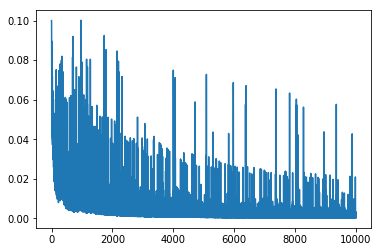

In [19]:
plt.plot(deltas)
plt.show()

In [20]:
# etermine the policy from Q*
policy = {}
V = {}
for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

#### result and optimal policy

In [21]:
print ("update counts:")
total = np.sum(update_counts.values())
for k, v in update_counts.iteritems():
    update_counts[k] = float(v) / total
print_values(update_counts, grid)

update counts:
---------------------------
 0.18|  0.18|  0.18|  0.00| 
---------------------------
 0.19|  0.00|  0.04|  0.00| 
---------------------------
 0.19|  0.02|  0.02|  0.00| 


In [24]:
print ("values:")
print_values(V, grid)
print ("optimal policy:")
print_policy(policy, grid)

values:
---------------------------
 0.50|  0.72|  1.00|  0.00| 
---------------------------
 0.29|  0.00|  0.73|  0.00| 
---------------------------
 0.12|  0.16|  0.41|  0.15| 
optimal policy:
---------------------------
  R  |   R  |   R  |      | 
---------------------------
  U  |      |   U  |      | 
---------------------------
  U  |   R  |   U  |   L  | 


## Case Two: Q-Learning

#### rewards

In [6]:
grid = negative_grid(step_cost=-0.1)
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10| -0.10| -0.10|  1.00| 
---------------------------
-0.10|  0.00| -0.10| -1.00| 
---------------------------
-0.10| -0.10| -0.10| -0.10| 


#### initializer: Q

In [8]:
Q = {}
states = grid.all_states()
for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0

In [9]:
# keep track of #Q[s] updated
update_counts = {}
update_counts_sa = {}
for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        update_counts_sa[s][a] = 1.0

#### Iteration (value iteration)

In [10]:
# Value convergency:
t = 1.0
deltas = []
for it in xrange(10000):
    if it % 100 == 0:
        t += 1e-2
    if it % 2000 == 0:
        print("it:", it)

    # instead of 'generating' an epsiode, PLAY an episode within this loop
    s = (2, 0) # start state
    grid.set_state(s)

    a, _ = max_dict(Q[s])
    biggest_change = 0
    while not grid.game_over():
        a = random_action(a, eps=0.5/t) # epsilon-greedy
        # random action also works, but slower since you can bump into walls
        r = grid.move(a)
        s2 = grid.current_state()

        # adaptive learning rate
        alpha = ALPHA / update_counts_sa[s][a]
        update_counts_sa[s][a] += 0.005

        # we will update Q(s,a) AS we experience the episode
        old_qsa = Q[s][a]
        # the difference between SARSA and Q-Learning is with Q-Learning
        # we will use this max[a']{ Q(s',a')} in our update
        # even if we do not end up taking this action in the next step
        a2, max_q_s2a2 = max_dict(Q[s2])
        Q[s][a] = Q[s][a] + alpha*(r + GAMMA*max_q_s2a2 - Q[s][a])
        biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

        # we would like to know how often Q(s) has been updated too
        update_counts[s] = update_counts.get(s,0) + 1

        # next state becomes current state
        s = s2
     
    deltas.append(biggest_change)

it: 0
it: 2000
it: 4000
it: 6000
it: 8000


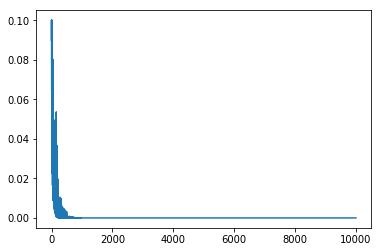

In [11]:
plt.plot(deltas)
plt.show()

In [12]:
# determine the policy from Q*
policy = {}
V = {}
for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

#### result and optimal policy

In [13]:
print ("update counts:")
total = np.sum(update_counts.values())
for k, v in update_counts.iteritems():
    update_counts[k] = float(v) / total
print_values(update_counts, grid)

update counts:
---------------------------
 0.27|  0.05|  0.04|  0.00| 
---------------------------
 0.12|  0.00|  0.01|  0.00| 
---------------------------
 0.28|  0.07|  0.05|  0.11| 


In [23]:
print ("values:")
print_values(V, grid)
print ("optimal policy:")
print_policy(policy, grid)

values:
---------------------------
 0.50|  0.72|  1.00|  0.00| 
---------------------------
 0.29|  0.00|  0.73|  0.00| 
---------------------------
 0.12|  0.16|  0.41|  0.15| 
optimal policy:
---------------------------
  R  |   R  |   R  |      | 
---------------------------
  U  |      |   U  |      | 
---------------------------
  U  |   R  |   U  |   L  | 
